### Предобработка


In [ ]:
import pandas as pd
df = pd.read_csv('RuFoLa фрагмент для практики.csv', encoding='utf-8')
# удаляем значения С2 -- их очень мало, они всё портят
df = df.drop(df[df['level_number'] == 6].index)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Загрузка данных из CSV df = pd.read_csv("RuFoLa_corpus.csv")

# Выводим информацию о датасете
# print(df.info())
# print(df.head(5))

# удаляем значения С2 -- их очень мало, они всё портят
df = df.drop(df[df['level'] == 6].index)
# делаем списки из нужных нам колонок
texts = df["text"].tolist()
labels = df["level"].tolist()

le = LabelEncoder()
labels = le.fit_transform(labels)

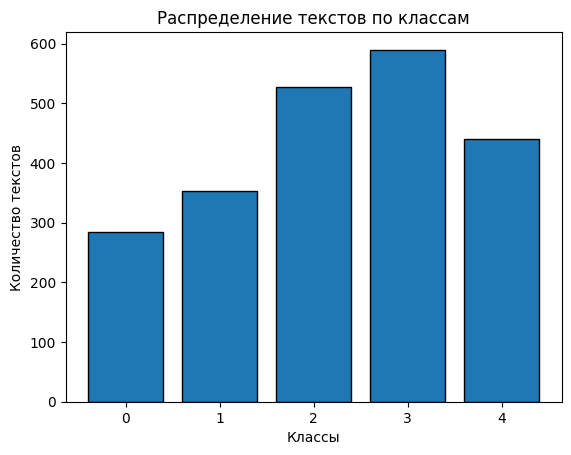

In [ ]:
# смотрим распределение данных по классам
import matplotlib.pyplot as plt

# Визуализация
plt.hist(labels, bins=np.arange(len(le.classes_)+1)-0.5, align='mid', rwidth=0.8, edgecolor='black')
plt.xlabel('Классы')
plt.ylabel('Количество текстов')
plt.title('Распределение текстов по классам')
plt.xticks(np.arange(len(le.classes_)))
plt.show()

In [ ]:
# разделеляем данные на обучающую и тестовую выборки
train_texts, vali_texts, train_labels, vali_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(vali_texts, vali_labels, test_size=0.5, random_state=42)
train_texts[:3]

['Добро пожаловать на юг России! Наш санаторий находится на берегу Чёрн моря. Вы будете жить в комфортабельн номерах с видом на море. Во вс номерах есть душ, туалет, телефон, телевизор, холодильник и мини-бар. Ценные вещи вы сможете хранить в сейф в свономерах. На завтрак, обед и ужин мы предлагаем большой выбор блюд, в том числе свёж фруктов. В наш бар и кафе отличный выбор десертов, алкоголя, холоди и горячих напйтк. Санаторий находится в ста метрах от моря. В первой половине дия вы можете загорать на шикарных морск пляж , плавать в тёпл море и в наших чист бассейнах, которые находятся на территории санатория. А вечером после ужина мы ждём вас на наших весёлых развлекательных программах. В наших спортивных зал мы предлагаем разлйчныеспортйвн программы, в том числе занятия налучшсовременных тренажёр. Врачи санатория посоветуют вам комплекс лечебных процедур для улучшения ваш здоровья. А в наш салоне красоты мы предлагаем курс разнообразных косметйческ процедур. В недорогих магазин наш

In [ ]:
from transformers import AutoTokenizer

model_name = "sberbank-ai/ruRoberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для подготовки данных
def tokenize_function(examples):
    return tokenizer(examples, truncation=True, padding="max_length", max_length=512)

val_encodings = tokenize_function(val_texts)
train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
       self.encodings = encodings
       self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)
    # Создаём датасеты для PyTorch
train_dataset = TextClassificationDataset(train_encodings, train_labels)
val_dataset = TextClassificationDataset(val_encodings, val_labels)
test_dataset = TextClassificationDataset(test_encodings, test_labels)

In [ ]:
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)  # Коэффициент детерминации (R^2)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    }


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
training_args = TrainingArguments(output_dir="trainer_logs",
                                  eval_strategy="epoch", save_strategy='epoch', num_train_epochs=3,
                                  load_best_model_at_end=True, disable_tqdm=False,
                                  per_device_train_batch_size=4, warmup_ratio=0.1,
                                  gradient_accumulation_steps=4,
                                  metric_for_best_model="mse")
trainer = Trainer(
    model=model,
    optimizers=(optimizer, None), # optimizers=(optimizer, scheduler)
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer), # добавляет паддинг в более короткие элементы батча
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics)
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: limonovaaa24 (limonovaaa24-michigan-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2
1,No log,0.583670,0.583670,0.763983,0.602293,0.675159
2,No log,0.476524,0.476524,0.690307,0.536613,0.734791
3,No log,0.492257,0.492257,0.701611,0.545362,0.726035


TrainOutput(global_step=291, training_loss=0.7878038858629993, metrics={'train_runtime': 1955.4064, 'train_samples_per_second': 2.358, 'train_steps_per_second': 0.149, 'total_flos': 4297120997188608.0, 'train_loss': 0.7878038858629993, 'epoch': 3.0})

In [ ]:
import json

# Оценка модели
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions # Убираем лишние измерения (если есть)
# predictions, labels = trainer.predict(val_dataset)

# Вычисление метрик для регрессии
mse = mean_squared_error(labels, preds)
mae = mean_absolute_error(labels, preds)
r2 = r2_score(labels, preds)

# Формирование отчёта
report = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

# # Сохранение отчёта в файл
# with open("regression_report_11.04_roberta-large.txt", "w", encoding="utf-8") as f:
#     json.dump(report, f, indent=4, ensure_ascii=False)

for k, v in report.items():
    print(k, v)

MSE 0.5836695432662964
MAE 0.6022927761077881
R2 0.6751592755317688


1. График "Предсказанные vs. Истинные значения" (Predicted vs. Actual Plot / Scatter Plot):

  •  Описание: Это, пожалуй, самый распространенный и полезный инструмент. Он отображает предсказанные значения по оси Y и истинные значения по оси X.
  •  Анализ:
    ×  Идеальная модель: Все точки должны лежать на диагональной линии (y = x).
    *  Систематические ошибки:
        Смещение:* Если точки в основном находятся выше или ниже диагональной линии, это указывает на систематическую переоценку или недооценку целевой переменной.
        Нелинейность:* Если точки образуют кривую, а не прямую линию, это говорит о том, что модель не может захватить нелинейные зависимости в данных.
    *  Разброс: Разброс точек вокруг линии указывает на величину ошибок. Больший разброс говорит о более низкой точности модели.
    *  Выбросы: Легко идентифицировать выбросы – точки, которые сильно отклоняются от основной массы данных.

0.5836695432662964 0.6022927761077881 0.6751592755317688
0.7154867649078369


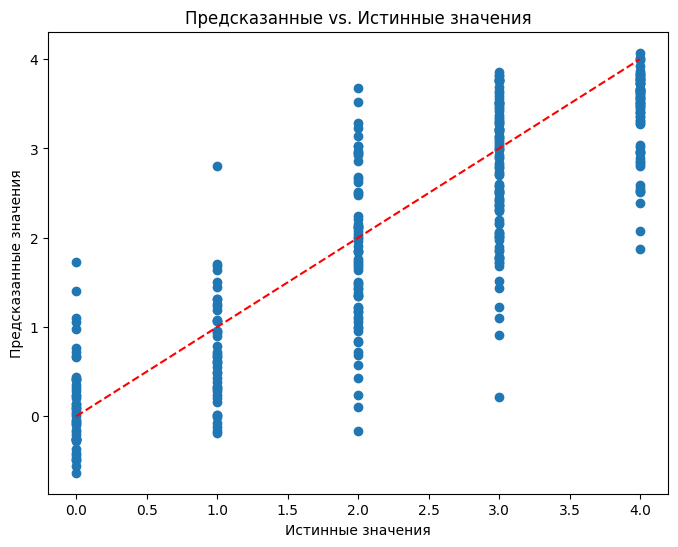

In [ ]:
 print(mse, mae, r2)
 from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = labels
y_pred = preds
print(explained_variance_score(labels, preds))
# 1. Scatter Plot (Predicted vs. Actual)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные vs. Истинные значения")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red')  # Add y=x line
plt.show()

2. График остатков (Residual Plot):

  •  Описание: Отображает остатки (разницу между предсказанными и истинными значениями) по оси Y и предсказанные или истинные значения по оси X.
  •  Анализ:
    ×  Идеальная модель: Остатки должны быть случайно распределены вокруг горизонтальной линии y = 0, без каких-либо видимых закономерностей.
    *  Непостоянная дисперсия (гетероскедастичность): Если разброс остатков увеличивается или уменьшается с увеличением предсказанных значений, это указывает на гетероскедастичность, что нарушает предположения многих регрессионных моделей.
    *  Нелинейность: Если на графике остатков видна какая-либо закономерность (например, кривая), это указывает на нелинейность, которую модель не учла.
    *  Выбросы: Остатки с большими абсолютными значениями являются выбросами.

307 307


ValueError: x and y must be the same size

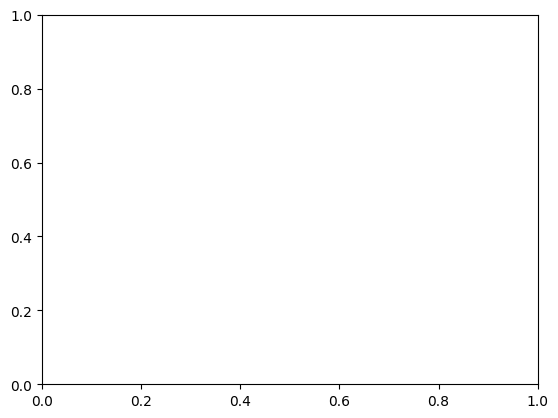

In [ ]:
residuals = y_true - y_pred
print(len(residuals), len(y_pred))
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("График остатков")
plt.axhline(y=0, color='red', linestyle='--')  # Add y=0 line
plt.show()

3. Гистограмма остатков (Histogram of Residuals):

  •  Описание: Отображает распределение остатков.
  •  Анализ:
    *  Идеальная модель: Распределение остатков должно быть близким к нормальному (колоколообразной формы) с центром в 0. Это одно из предположений линейной регрессии.
    *  Смещение: Если распределение смещено вправо или влево, это указывает на систематическую переоценку или недооценку.
    *  Тяжелые хвосты: Тяжелые хвосты (большое количество выбросов) указывают на то, что модель плохо предсказывает некоторые значения.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


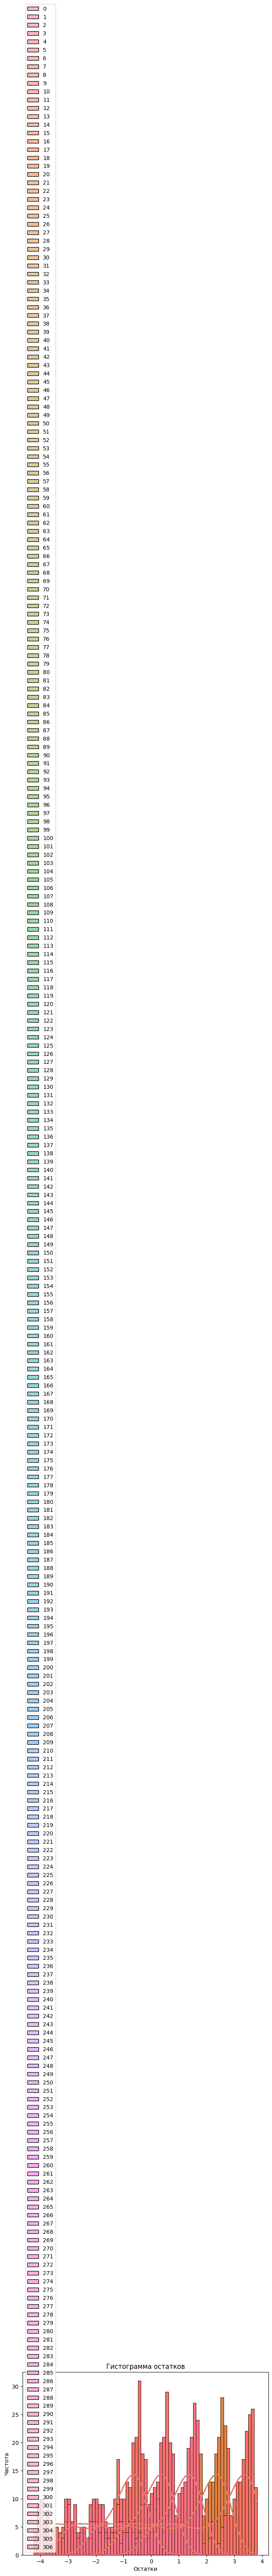

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True) #kde for a smooth line
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.title("Гистограмма остатков")
plt.show()